In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, make_scorer, roc_curve

%matplotlib inline

# Churn

In [49]:
df_churn = pd.read_csv("fdb_churn_train.csv", index_col=0)
df_churn["next_3_months_spend"] = df_churn["next_3_months_spend"].fillna(0)

In [50]:
y1 = df_churn.churn
y2 = df_churn.next_3_months_spend
X = df_churn.iloc[:,:-2]

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2653 entries, 535 to 3174
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               2653 non-null   float64
 1   first_purchase_date      2653 non-null   object 
 2   last_purchase_date       2653 non-null   object 
 3   total_purchases          2653 non-null   int64  
 4   total_purchase_amount_x  2653 non-null   float64
 5   last_3_months_spend      2653 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 145.1+ KB


In [52]:
df_churn.sum()

CustomerID                                                       4.05499e+07
first_purchase_date        2011-06-092011-01-112011-02-102011-07-122011-0...
last_purchase_date         2011-06-092011-01-112011-04-072011-07-122011-0...
total_purchases                                                         8333
total_purchase_amount_x                                          4.46622e+06
last_3_months_spend                                              1.64521e+06
next_3_months_spend                                              2.24836e+06
churn                                                                   1142
dtype: object

In [53]:
df_churn["last_purchase_date"].max()

'2011-08-31'

In [54]:
X["length"] = (pd.to_datetime(df_churn.last_purchase_date) - 
                     pd.to_datetime(df_churn.first_purchase_date)).apply(lambda x:x.days)
X["recency"] = (pd.to_datetime("2011-09-01") - 
                     pd.to_datetime(df_churn.last_purchase_date)).apply(lambda x:x.days)

In [55]:
X = X.iloc[:,3:]

In [56]:
# Split train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y1, shuffle=True, test_size=0.2, random_state=42, stratify=y1)
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42, stratify=y1)


In [57]:
def model_scores(model, X, y):
    y_hat = model.predict(X)
    print(f"Accuracy: {accuracy_score(y, y_hat).round(3)} \t Recall: {recall_score(y, y_hat).round(3)} \t Precision: {precision_score(y, y_hat).round(3)} \t F1: {f1_score(y, y_hat).round(3)}")
    return accuracy_score(y, y_hat), recall_score(y, y_hat), precision_score(y, y_hat), f1_score(y, y_hat)

In [58]:
y_train.mean()

0.4302544769085768

## Logistic Regression

In [59]:
# logister 
# class_weight
weights = {0:0.1, 1:1.0}
# lr = LogisticRegression(class_weight=weights)
lr = LogisticRegression()
lr.fit(X_train, y_train)

model_scores(lr, X_train, y_train)

Accuracy: 0.681 	 Recall: 0.585 	 Precision: 0.642 	 F1: 0.612


(0.680961357210179, 0.5848849945235487, 0.6418269230769231, 0.6120343839541547)

In [60]:
model_scores(lr, X_test, y_test)

Accuracy: 0.665 	 Recall: 0.524 	 Precision: 0.635 	 F1: 0.574


(0.664783427495292, 0.5240174672489083, 0.6349206349206349, 0.5741626794258374)

In [1182]:
weights_list = [{0:0.01, 1:1.0}, {0:0.003, 1:1.0}, {0:0.05, 1:1.0}, {0:0.1, 1:1.0}, {0:0.15, 1:1.0}, {0:0.2, 1:1.0}]
parameters = {'class_weight': weights_list}

In [1183]:
f1_scorer = make_scorer(f1_score)
gslr = GridSearchCV(lr, 
                    parameters#,                   scoring=f1_scorer
                   )
gslr.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [{0: 0.01, 1: 1.0}, {0: 0.003, 1: 1.0},
                                          {0: 0.05, 1: 1.0}, {0: 0.1, 1: 1.0},
                                          {0: 0.15, 1: 1.0},
                                          {0: 0.2, 1: 1.0}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

In [1184]:
pd.DataFrame(gslr.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.0213432,0.0188436,0.0149413,0.0137173,0.0117781,0.0134012
std_fit_time,0.00155735,0.00180905,0.000502015,0.00067846,0.000495462,0.000769515
mean_score_time,0.00131593,0.000940943,0.000897408,0.00089674,0.000926447,0.000924826
std_score_time,0.000161867,3.90205e-05,3.89331e-05,4.08005e-05,6.4775e-05,5.76664e-05
param_class_weight,"{0: 0.01, 1: 1.0}","{0: 0.003, 1: 1.0}","{0: 0.05, 1: 1.0}","{0: 0.1, 1: 1.0}","{0: 0.15, 1: 1.0}","{0: 0.2, 1: 1.0}"
params,"{'class_weight': {0: 0.01, 1: 1.0}}","{'class_weight': {0: 0.003, 1: 1.0}}","{'class_weight': {0: 0.05, 1: 1.0}}","{'class_weight': {0: 0.1, 1: 1.0}}","{'class_weight': {0: 0.15, 1: 1.0}}","{'class_weight': {0: 0.2, 1: 1.0}}"
split0_test_score,0.47973,0.47973,0.509009,0.531532,0.54955,0.567568
split1_test_score,0.502252,0.490991,0.52027,0.540541,0.558559,0.56982
split2_test_score,0.493243,0.488739,0.509009,0.540541,0.563063,0.572072
split3_test_score,0.496614,0.492099,0.51693,0.548533,0.58465,0.602709


## random forest

In [61]:
## random forest

rf = RandomForestClassifier(criterion= 'gini', max_depth = 4, max_features = 'sqrt')

rf.fit(X_train, y_train)

model_scores(rf, X_train, y_train)

Accuracy: 0.717 	 Recall: 0.712 	 Precision: 0.658 	 F1: 0.684


(0.7167766258246937,
 0.7119386637458927,
 0.6578947368421053,
 0.6838506049447659)

In [62]:
model_scores(rf, X_test, y_test)

Accuracy: 0.682 	 Recall: 0.642 	 Precision: 0.628 	 F1: 0.635


(0.6817325800376648, 0.6419213973799127, 0.6282051282051282, 0.634989200863931)

In [33]:
rf_params = {'criterion': ('gini', 'entropy'), 'max_depth': [2, 3, 4],
              'max_features': [1, 'sqrt', 'log2', None]}

In [34]:
gsrf = GridSearchCV(rf, 
                    rf_params#,scoring=f1_scorer
                   )
gsrf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy', max_depth=3,
                                              max_features=1,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_

In [35]:
pd.DataFrame(gsrf.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,0.100279,0.107545,0.112162,0.146185,0.129206,0.122467,0.136948,0.161951,0.109373,0.125505,...,0.119061,0.167453,0.112322,0.141561,0.136062,0.208767,0.121159,0.154605,0.154926,0.250788
std_fit_time,0.00870281,0.00161408,0.00560645,0.0150514,0.0182725,0.00296646,0.0220137,0.00281025,0.00297489,0.00122519,...,0.000939665,0.00224417,0.00132507,0.00356349,0.00133199,0.00131018,0.000884347,0.00166127,0.00121183,0.00126263
mean_score_time,0.00762649,0.00768642,0.0078176,0.00857091,0.00909877,0.00830774,0.00868945,0.00832725,0.00805397,0.00797596,...,0.00752525,0.00758834,0.00784297,0.00793567,0.00782409,0.00773635,0.0079103,0.00798092,0.00818114,0.00798259
std_score_time,0.000195175,0.000257806,0.000440164,0.0015206,0.00138402,0.000206613,0.00140508,0.00098667,6.39528e-05,5.61421e-05,...,0.000228169,0.000140714,0.000147738,8.85532e-05,0.000172108,0.000172212,0.000137515,0.000160817,0.000211105,0.000118969
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,...,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_max_depth,2,2,2,2,3,3,3,3,4,4,...,2,2,3,3,3,3,4,4,4,4
param_max_features,1,sqrt,log2,None,1,sqrt,log2,None,1,sqrt,...,log2,None,1,sqrt,log2,None,1,sqrt,log2,None
params,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 3, 'max_fea...","{'criterion': 'gini', 'max_depth': 3, 'max_fea...","{'criterion': 'gini', 'max_depth': 3, 'max_fea...","{'criterion': 'gini', 'max_depth': 3, 'max_fea...","{'criterion': 'gini', 'max_depth': 4, 'max_fea...","{'criterion': 'gini', 'max_depth': 4, 'max_fea...",...,"{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 3, 'max_...","{'criterion': 'entropy', 'max_depth': 3, 'max_...","{'criterion': 'entropy', 'max_depth': 3, 'max_...","{'criterion': 'entropy', 'max_depth': 3, 'max_...","{'criterion': 'entropy', 'max_depth': 4, 'max_...","{'criterion': 'entropy', 'max_depth': 4, 'max_...","{'criterion': 'entropy', 'max_depth': 4, 'max_...","{'criterion': 'entropy', 'max_depth': 4, 'max_..."
split0_test_score,0.677928,0.65991,0.675676,0.677928,0.682432,0.68018,0.684685,0.695946,0.68018,0.689189,...,0.68018,0.689189,0.691441,0.684685,0.693694,0.689189,0.677928,0.68018,0.684685,0.691441
split1_test_score,0.677928,0.677928,0.682432,0.655405,0.686937,0.693694,0.693694,0.689189,0.686937,0.691441,...,0.655405,0.650901,0.682432,0.691441,0.686937,0.686937,0.693694,0.695946,0.695946,0.70045


In [36]:
gsrf.best_params_

{'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt'}

------
## GradientBoostingClassifier

In [63]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()

def sw(weight_a, weight_b):
    sample_weights = np.zeros(len(y_train))
    sample_weights[y_train == 0] = weight_a
    sample_weights[y_train == 1] = weight_b
    return sample_weights

sample_weights = sw(0.5, 3)

gbc.fit(X_train, y_train, sample_weight = sample_weights
       )

model_scores(gbc, X_train, y_train)


Accuracy: 0.639 	 Recall: 0.997 	 Precision: 0.544 	 F1: 0.704


(0.6394910461828464,
 0.9967141292442497,
 0.5442583732057417,
 0.7040618955512573)

In [64]:
model_scores(gbc, X_test, y_test)

Accuracy: 0.591 	 Recall: 0.913 	 Precision: 0.515 	 F1: 0.658


(0.591337099811676, 0.9126637554585153, 0.5147783251231527, 0.658267716535433)

In [127]:
sample_weights_list = [sw(0.5, 9.1), sw(0.5, 5), sw(1, 5), sw(0.2, 10)]
# gbc_params = {'sample_weight': sample_weights_list}

In [128]:
# gsgbc = GridSearchCV(gbc, 
#                     gbc_params,
#                    scoring=f1_scorer)
# gsgbc.fit(X_train, y_train)

ValueError: Invalid parameter sample_weight for estimator GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
# pd.DataFrame(gsgbc.cv_results_).T

## KNN

In [65]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=45)

knn.fit(X_train, y_train)

model_scores(knn, X_train, y_train)


Accuracy: 0.694 	 Recall: 0.662 	 Precision: 0.64 	 F1: 0.651


(0.6941564561734213,
 0.6615553121577218,
 0.6398305084745762,
 0.6505115778136781)

In [66]:
model_scores(knn, X_test, y_test)

Accuracy: 0.682 	 Recall: 0.624 	 Precision: 0.633 	 F1: 0.629


(0.6817325800376648,
 0.6244541484716157,
 0.6327433628318584,
 0.6285714285714286)

In [1267]:
knn_params = {'n_neighbors': list(range(3,50,2))}

In [1268]:
gsknn = GridSearchCV(knn, 
                    knn_params#,scoring=f1_scorer
                    )
gsknn.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=41, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [1269]:
pd.DataFrame(gsknn.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,0.00295391,0.00223923,0.00219564,0.00238314,0.00227828,0.00244646,0.00226021,0.00219221,0.00226245,0.0022553,...,0.00252252,0.00222368,0.0022305,0.00231695,0.00226717,0.00221033,0.00230284,0.00240064,0.00227852,0.00230374
std_fit_time,0.000496496,0.000130042,0.000138023,0.00026815,0.000127409,0.000389736,6.31018e-05,5.01837e-05,0.00011642,9.44675e-05,...,0.0004225,7.07909e-05,0.000201012,0.000103285,8.88888e-05,6.7445e-05,7.25052e-05,0.000274056,0.000106967,9.65188e-05
mean_score_time,0.0134285,0.0105559,0.011052,0.0113822,0.0112647,0.0109583,0.0115996,0.0114863,0.0115425,0.0120564,...,0.0126883,0.0125957,0.0124089,0.0135271,0.0129546,0.013153,0.012858,0.0129954,0.0134392,0.0135188
std_score_time,0.00174374,0.000295578,0.00033026,0.000289573,0.0004478,0.000189205,0.000349627,0.00028609,0.00043039,0.000318682,...,0.000645898,0.000331556,0.000380456,0.00166361,0.000252009,0.000279148,0.000172258,0.000338036,0.000362834,0.000536593
param_n_neighbors,3,5,7,9,11,13,15,17,19,21,...,31,33,35,37,39,41,43,45,47,49
params,{'n_neighbors': 3},{'n_neighbors': 5},{'n_neighbors': 7},{'n_neighbors': 9},{'n_neighbors': 11},{'n_neighbors': 13},{'n_neighbors': 15},{'n_neighbors': 17},{'n_neighbors': 19},{'n_neighbors': 21},...,{'n_neighbors': 31},{'n_neighbors': 33},{'n_neighbors': 35},{'n_neighbors': 37},{'n_neighbors': 39},{'n_neighbors': 41},{'n_neighbors': 43},{'n_neighbors': 45},{'n_neighbors': 47},{'n_neighbors': 49}
split0_test_score,0.635135,0.644144,0.662162,0.655405,0.65991,0.644144,0.668919,0.65991,0.655405,0.650901,...,0.646396,0.650901,0.655405,0.657658,0.657658,0.650901,0.648649,0.650901,0.653153,0.653153
split1_test_score,0.628378,0.617117,0.635135,0.646396,0.65991,0.644144,0.653153,0.671171,0.668919,0.668919,...,0.65991,0.65991,0.668919,0.671171,0.668919,0.668919,0.664414,0.682432,0.675676,0.673423
split2_test_score,0.619369,0.63964,0.626126,0.666667,0.662162,0.664414,0.666667,0.655405,0.666667,0.671171,...,0.675676,0.668919,0.671171,0.668919,0.668919,0.673423,0.677928,0.677928,0.671171,0.68018
split3_test_score,0.647856,0.659142,0.672686,0.668172,0.688488,0.693002,0.702032,0.702032,0.699774,0.706546,...,0.711061,0.715576,0.711061,0.711061,0.711061,0.706546,0.713318,0.702032,0.704289,0.704289


## Support Vector Machine

In [67]:
# SVM

svm = SVC(kernel='rbf'
    ,probability=True)

svm.fit(X_train, y_train)

model_scores(svm, X_train, y_train)

Accuracy: 0.664 	 Recall: 0.802 	 Precision: 0.579 	 F1: 0.672


(0.6639962299717248,
 0.8017524644030668,
 0.5791139240506329,
 0.6724850711988977)

In [68]:
model_scores(svm, X_test, y_test)

Accuracy: 0.665 	 Recall: 0.751 	 Precision: 0.587 	 F1: 0.659


(0.664783427495292, 0.7510917030567685, 0.5870307167235495, 0.6590038314176245)

In [1472]:
weights_list = ["balanced", {0:0.01, 1:1.0}, {0:0.003, 1:1.0}, {0:0.05, 1:1.0}, {0:0.1, 1:1.0}, {0:0.15, 1:1.0}, {0:0.2, 1:1.0}]

svm_params = {"kernel": ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed')}

In [ ]:
gssvm = GridSearchCV(svm, 
                    svm_params#,                   scoring=f1_scorer
                    )
gssvm.fit(X_train, y_train)

In [160]:
pd.DataFrame(gssvm.cv_results_).T

,0,1,2,3,4,5,6
mean_fit_time,23.5735,22.111,22.0102,23.5942,24.6875,26.3163,26.2146
std_fit_time,0.694025,1.8366,1.67897,0.808296,0.804636,1.23976,1.90191
mean_score_time,0.0125141,0.0126651,0.0114753,0.0139561,0.0106471,0.0125728,0.0117753
std_score_time,0.00095126,0.00119365,0.00105556,0.00196089,0.000819926,0.0017456,0.00109966
param_class_weight,balanced,"{0: 0.01, 1: 1.0}","{0: 0.003, 1: 1.0}","{0: 0.05, 1: 1.0}","{0: 0.1, 1: 1.0}","{0: 0.15, 1: 1.0}","{0: 0.2, 1: 1.0}"
params,{'class_weight': 'balanced'},"{'class_weight': {0: 0.01, 1: 1.0}}","{'class_weight': {0: 0.003, 1: 1.0}}","{'class_weight': {0: 0.05, 1: 1.0}}","{'class_weight': {0: 0.1, 1: 1.0}}","{'class_weight': {0: 0.15, 1: 1.0}}","{'class_weight': {0: 0.2, 1: 1.0}}"
split0_test_score,0.0150164,0.047619,0.167401,0,0,0,0.0140845
split1_test_score,0,0.0213523,0.144928,0.00165098,0,0,0
split2_test_score,0,0.136646,0.22619,0.0148883,0,0.0280702,0.0210526
split3_test_score,0.0094231,0.0509554,0.150602,0,0,0.177936,0.107198


In [69]:
lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])

knn_fpr, knn_tpr, knn_thresh = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])

rf_fpr, rf_tpr, rf_thresh = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

gbc_fpr, gbc_tpr, gbc_thresh = roc_curve(y_test, gbc.predict_proba(X_test)[:, 1])

svm_fpr, svm_tpr, svm_thresh = roc_curve(y_test, svm.predict_proba(X_test)[:, 1])


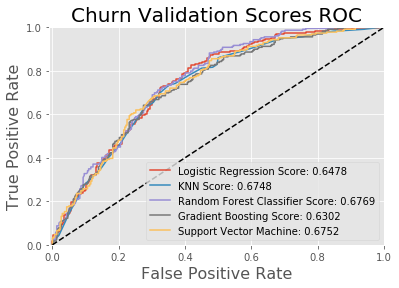

In [70]:

plt.plot(lr_fpr, lr_tpr, label='Logistic Regression Score: {:.4f}'.format(roc_auc_score(y_test, lr.predict(X_test))))

plt.plot(knn_fpr, knn_tpr, label='KNN Score: {:.4f}'.format(roc_auc_score(y_test, knn.predict(X_test))))

plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_test, rf.predict(X_test))))

plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Score: {:.4f}'.format(roc_auc_score(y_test, gbc.predict(X_test))))

plt.plot(svm_fpr, svm_tpr, label='Support Vector Machine: {:.4f}'.format(roc_auc_score(y_test, svm.predict(X_test))))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.title('Churn Validation Scores ROC', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right')
plt.show()

## Testing

In [71]:
df_train = pd.concat([X_train, y_train,y_train2], axis=1)
train_for_predict = df_train.groupby("churn").last_3_months_spend.mean()


In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2122 entries, 916 to 992
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total_purchases          2122 non-null   int64  
 1   total_purchase_amount_x  2122 non-null   float64
 2   last_3_months_spend      2122 non-null   float64
 3   length                   2122 non-null   int64  
 4   recency                  2122 non-null   int64  
 5   churn                    2122 non-null   int64  
 6   next_3_months_spend      2122 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 132.6 KB


In [73]:
test_pre = pd.Series(rf.predict(X_test)).value_counts().sort_index().dot(train_for_predict)

In [74]:
test_pre = ((1- rf.predict(X_test)) * X_test["last_3_months_spend"]).sum()

In [75]:
test_act = y_test2.sum(); test_act

513337.38

In [76]:
test_pre/test_act - 1

-0.12866129094281042

In [77]:
predict = (1- rf.predict(X_test)) * X_test["last_3_months_spend"]
RMSE = (((predict - y_test2)**2).sum() / y_test2.shape[0]) **0.5; RMSE

3404.0814225522777

_______
# RFM


## RFM2X2X2

In [88]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0)

In [89]:
df_RFM["RFM"] = df_RFM["RFM"].fillna("1-1-1")
df_RFM["next_3_months_spend"] = df_RFM["next_3_months_spend"].fillna(0)

In [90]:
df_RFM["RFM"].value_counts()/df_RFM["RFM"].count()

1-1-1    0.517904
1-1-2    0.254806
2-2-2    0.076140
1-2-2    0.056540
2-1-2    0.050886
2-1-1    0.020731
2-2-1    0.013570
1-2-1    0.009423
Name: RFM, dtype: float64

In [91]:
y1 = df_RFM.RFM
y2 = df_RFM.next_3_months_spend
X = df_RFM.iloc[:,:-2]

In [92]:
X["length"] = (pd.to_datetime(df_RFM.last_purchase_date) - 
                     pd.to_datetime(df_RFM.first_purchase_date)).apply(lambda x:x.days)
X["recency"] = (pd.to_datetime("2011-09-01") - 
                     pd.to_datetime(df_RFM.last_purchase_date)).apply(lambda x:x.days)
X = X.iloc[:,3:]

In [93]:
# X_train, y_train, X_test, y_test = train_test_split(X, y1, random_state=42, stratefy)""
X_train, X_test, y_train, y_test = train_test_split(X, y1, shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42)

In [94]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=41)

knn.fit(X_train, y_train)

# model_scores(knn, X_train, y_train)

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print(accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 

0.591337099811676


In [1321]:
knn_params = {'n_neighbors': list(range(3,50,2))}
gsknn = GridSearchCV(knn, 
                    knn_params)
gsknn.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=35, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [1322]:
pd.DataFrame(gsknn.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,0.00365553,0.00376887,0.00328102,0.003195,0.0030601,0.00333529,0.00359793,0.0030066,0.00316086,0.00318012,...,0.00312052,0.00307908,0.00317192,0.0030736,0.00301619,0.00323739,0.00325041,0.00311894,0.00309911,0.00309668
std_fit_time,0.000419741,0.000941901,0.00030757,0.000299377,0.000130784,0.000117424,0.00102857,0.000136957,0.000219671,0.000178661,...,0.000248952,0.00010497,8.26353e-05,5.49565e-05,7.86046e-05,0.00045274,0.000317031,0.000144018,0.000250905,0.000224166
mean_score_time,0.0132999,0.0114943,0.0110285,0.0116169,0.0120514,0.0133659,0.0126091,0.0118086,0.0121057,0.0123737,...,0.0129084,0.0129228,0.0140081,0.0132026,0.013529,0.013174,0.0134081,0.0134915,0.0137475,0.0138155
std_score_time,0.00155707,0.000400701,0.000203332,0.000310362,0.000739841,0.000765965,0.000947028,0.000472515,0.000542082,0.000501283,...,0.000297164,0.00049489,0.00082914,0.000339626,0.000633333,0.000383672,0.000525647,0.000403557,0.000392289,0.000325261
param_n_neighbors,3,5,7,9,11,13,15,17,19,21,...,31,33,35,37,39,41,43,45,47,49
params,{'n_neighbors': 3},{'n_neighbors': 5},{'n_neighbors': 7},{'n_neighbors': 9},{'n_neighbors': 11},{'n_neighbors': 13},{'n_neighbors': 15},{'n_neighbors': 17},{'n_neighbors': 19},{'n_neighbors': 21},...,{'n_neighbors': 31},{'n_neighbors': 33},{'n_neighbors': 35},{'n_neighbors': 37},{'n_neighbors': 39},{'n_neighbors': 41},{'n_neighbors': 43},{'n_neighbors': 45},{'n_neighbors': 47},{'n_neighbors': 49}
split0_test_score,0.504505,0.54955,0.56982,0.56982,0.578829,0.592342,0.576577,0.581081,0.56982,0.585586,...,0.585586,0.585586,0.583333,0.592342,0.587838,0.587838,0.587838,0.59009,0.594595,0.59009
split1_test_score,0.540541,0.504505,0.536036,0.558559,0.556306,0.560811,0.556306,0.572072,0.581081,0.574324,...,0.574324,0.563063,0.581081,0.576577,0.581081,0.583333,0.581081,0.578829,0.587838,0.59009
split2_test_score,0.513514,0.531532,0.536036,0.556306,0.572072,0.556306,0.563063,0.563063,0.565315,0.565315,...,0.558559,0.565315,0.556306,0.554054,0.556306,0.560811,0.558559,0.54955,0.54955,0.556306
split3_test_score,0.525959,0.514673,0.532731,0.546275,0.555305,0.544018,0.546275,0.546275,0.557562,0.555305,...,0.566591,0.562077,0.564334,0.566591,0.562077,0.562077,0.555305,0.555305,0.557562,0.555305


In [95]:
## random forest

rf = RandomForestClassifier(class_weight = 'balanced',
                             criterion = 'entropy',
                             max_depth = 40,
                             max_features = 'log2')

rf.fit(X_train, y_train)

accuracy = rf.score(X_test, y_test) 
print(accuracy) 

# model_scores(rf, X_train, y_train)

0.6064030131826742


In [97]:
rf_predictions = rf.predict(X_test)  
cm = confusion_matrix(y_test, rf_predictions) 

In [1324]:
rf_params = {"class_weight" :['balanced'],'criterion': ('gini', 'entropy'), 'max_depth': [25,40,80],
              'max_features': [1, 'sqrt', 'log2']}

In [1325]:
gsrf = GridSearchCV(rf, 
                    rf_params)
gsrf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='entropy', max_depth=25,
                                              max_features='log2',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                         

In [1326]:
pd.DataFrame(gsrf.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,0.20418,0.265069,0.261312,0.199941,0.258561,0.25946,0.199466,0.260744,0.258087,0.407713,0.575406,0.572094,0.404636,0.574572,0.568753,0.402637,0.587956,0.626952
std_fit_time,0.00927923,0.00739025,0.0027195,0.0013928,0.0014718,0.00282682,0.00179886,0.00361363,0.00115296,0.0179795,0.0120586,0.0130625,0.0151294,0.0158014,0.0118793,0.0134654,0.00892602,0.0438098
mean_score_time,0.0151642,0.0150477,0.0147654,0.0147791,0.0149771,0.0145866,0.0150001,0.014455,0.0148261,0.0150587,0.0142219,0.0143792,0.0147377,0.0142142,0.0146426,0.0144598,0.0143979,0.0157276
std_score_time,0.000928516,0.000686082,0.000342848,0.000312513,0.000891939,0.00054085,0.000481043,0.000459589,0.000658747,0.000355844,0.000249608,0.000346961,0.000469235,0.000348905,0.000394852,0.000526946,0.000936534,0.00207682
param_class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_max_depth,25,25,25,40,40,40,80,80,80,25,25,25,40,40,40,80,80,80
param_max_features,1,sqrt,log2,1,sqrt,log2,1,sqrt,log2,1,sqrt,log2,1,sqrt,log2,1,sqrt,log2
params,"{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent..."
split0_test_score,0.56982,0.574324,0.565315,0.56982,0.565315,0.563063,0.563063,0.578829,0.563063,0.54955,0.572072,0.565315,0.567568,0.567568,0.576577,0.563063,0.560811,0.565315


In [1308]:
gsrf.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 1}

In [96]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.05)

gbc.fit(X_train, y_train)

accuracy = gbc.score(X_test, y_test) 
print(accuracy) 


0.591337099811676


In [87]:
gbc_predictions = gbc.predict(X_test)  
cm = confusion_matrix(y_test, gbc_predictions) 

## multilabel

In [1087]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0)
df_RFM["RFM"] = df_RFM["RFM"].fillna("1-1-1")
df_RFM["next_3_months_spend"] = df_RFM["next_3_months_spend"].fillna(0)
y1 = df_RFM.RFM
y2 = df_RFM.next_3_months_spend
X = df_RFM.iloc[:,:-3]

In [1088]:
X["length"] = (pd.to_datetime(df_RFM.last_purchase_date) - 
                     pd.to_datetime(df_RFM.first_purchase_date)).apply(lambda x:x.days)
X["recency"] = (pd.to_datetime("2012-12-02") - 
                     pd.to_datetime(df_RFM.last_purchase_date)).apply(lambda x:x.days)
X = X.iloc[:,3:]

In [1089]:
R = df_RFM["RFM"].apply(lambda x:int(x[0])-1)
F = df_RFM["RFM"].apply(lambda x:int(x[2])-1)
M = df_RFM["RFM"].apply(lambda x:int(x[4])-1)
y1_1 = pd.concat([R,F,M], axis=1)
y1_1.columns =["R","F","M"]

In [1090]:
X_train, X_test, y_train, y_test = train_test_split(X, y1_1, shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42)

In [1091]:
## random forest

rf = RandomForestClassifier(class_weight = 'balanced',
                             criterion = 'gini',
                             max_depth = 25,
                             max_features = 1)

rf.fit(X_train, y_train)

accuracy = rf.score(X_test, y_test) 
print(accuracy) 

0.45045045045045046


In [1092]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=19)

knn.fit(X_train, y_train)

# model_scores(knn, X_train, y_train)

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print(accuracy) 

0.5801801801801801


## testing

In [98]:
df_train = pd.concat([X_train, y_train,y_train2], axis=1)
train_for_predict = df_train.groupby("RFM").last_3_months_spend.mean()


In [99]:
X_test["predict"] = gbc_predictions

In [100]:
tempdf = pd.DataFrame(train_for_predict)

In [101]:
tempdf["predict_counts"] = pd.Series(gbc_predictions).value_counts()

In [102]:
tempdf.fillna(0, inplace=True)

In [103]:
y_test3 = pd.concat([y_test,y_test2], axis=1)
test_act = y_test3.groupby("RFM").sum().sum()
test_pre = tempdf.last_3_months_spend.dot(tempdf.predict_counts)
# test_pre = pd.Series(gbc_predictions).value_counts().sort_index().dot(train_for_predict)
test_act = y_test2.sum()

In [104]:
test_act

468087.9700000001

In [105]:
test_pre/test_act - 1

-0.516433849970855

# LTV

In [704]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0);df_RFM

,CustomerID,first_purchase_date,last_purchase_date,total_purchases,total_purchase_amount_x,last_2_months_spend,RFM,next_2_months_spend
3386,13584.0,2011-02-06,2011-02-06,1,142.40,0.00,1-1-1,0.00
343,14553.0,2011-01-04,2011-05-05,2,312.32,0.00,1-1-2,546.95
1588,17929.0,2011-02-04,2011-09-23,4,698.50,263.50,2-1-1,136.00
1601,15053.0,2011-03-03,2011-07-06,2,478.60,0.00,1-1-1,0.00
678,13659.0,2011-01-23,2011-05-26,3,1550.85,0.00,1-1-1,0.00
...,...,...,...,...,...,...,...,...
1130,13892.0,2011-04-07,2011-04-07,1,54.52,0.00,1-2-2,578.45
1294,14730.0,2011-03-08,2011-08-24,5,904.21,137.14,1-1-2,855.92
860,15955.0,2010-12-02,2011-09-29,7,2956.04,1520.37,1-2-2,1433.77
3507,18138.0,2011-02-17,2011-02-17,1,152.65,0.00,1-1-1,0.00


In [705]:
y1 = df_RFM.RFM
y2 = df_RFM.next_2_months_spend
X = df_RFM.iloc[:,:-2]

In [706]:
# X_train, y_train, X_test, y_test = train_test_split(X, y1, random_state=42, stratefy)""
X_train, X_test, y_train, y_test = train_test_split(X, y1, shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42)

In [709]:
df_RFM = X_train

In [740]:
df_RFM = X_test

In [741]:
df_RFM["T"] = (pd.to_datetime("2011-10-01") - pd.to_datetime(
                df_RFM["first_purchase_date"]) ).apply(lambda x:x.days)
df_RFM["recency"] = (pd.to_datetime(df_RFM["last_purchase_date"])  
                     - pd.to_datetime(df_RFM["first_purchase_date"])).apply(lambda x:x.days)
df_RFM["frequency"] = (df_RFM["total_purchases"] - 1)

data = df_RFM[["frequency", "recency", "T"]]

In [745]:
data

,frequency,recency,T
1666,10,234,258
3575,3,216,222
1535,0,0,2
606,4,168,171
1249,0,0,86
...,...,...,...
1952,0,0,289
3016,1,27,113
1679,0,0,78
681,0,0,85


In [715]:
g1 = data.groupby('frequency')

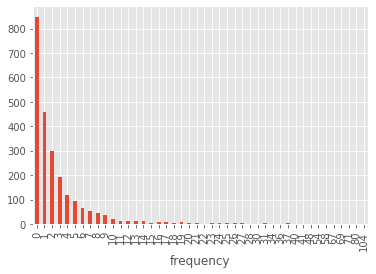

In [716]:
g1['frequency'].count().plot(kind="bar")

In [717]:
g2 = data.groupby('T')

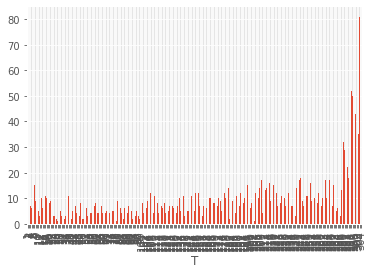

In [718]:
g2['T'].count().plot(kind="bar")

## Pareto-NPD

In [561]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(data['frequency'], data['recency'], data['T'])


bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.633748,0.023724,0.587248,0.680248
alpha,43.215597,2.183869,38.935215,47.495980
a,0.011330,0.004182,0.003133,0.019527
b,0.158515,0.046874,0.066642,0.250388


----

In [593]:
from lifetimes.fitters.beta_geo_beta_binom_fitter import BetaGeoBetaBinomFitter

bgf = BetaGeoBetaBinomFitter(penalizer_coef=0.03)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoBetaBinomFitter: fitted with 2340 subjects, alpha: 0.22, beta: 1.87, delta: 0.77, gamma: 0.07>

In [421]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
alpha,0.217026,0.006755,0.203786,0.230266
beta,1.870713,0.059985,1.753142,1.988284
gamma,0.068338,0.004419,0.059678,0.076998
delta,0.773649,0.057392,0.661160,0.886137


----

In [719]:
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter

In [720]:
bgf = ParetoNBDFitter(penalizer_coef=0.04)

bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.ParetoNBDFitter: fitted with 2340 subjects, alpha: 58.93, beta: 6.06, r: 0.86, s: 0.03>

----

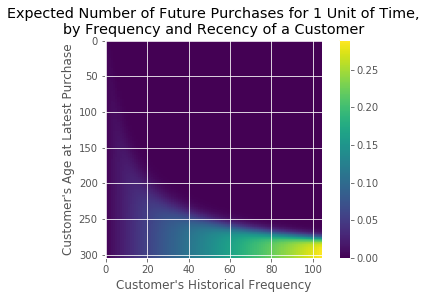

In [721]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf,
                             ylabel="Customer's Age at Latest Purchase")

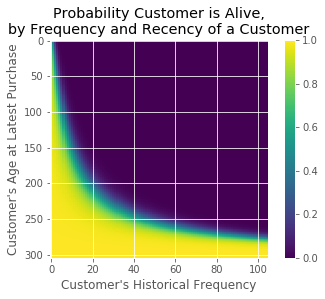

In [722]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf,
                             ylabel="Customer's Age at Latest Purchase")

In [746]:
t = 61
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
1054,32,302,303,5.524512
1530,34,302,303,5.860714
3254,34,288,299,5.915858
3336,34,276,285,6.158441
3610,83,301,304,14.054872


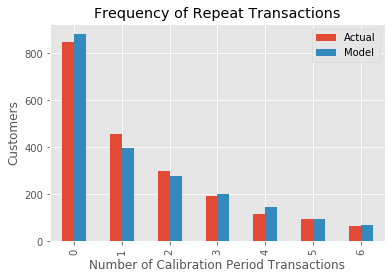

In [724]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## Gamma-Gamma

In [748]:
data2 = df_RFM[["frequency", "recency", "T", "total_purchase_amount_x"]]
data2["monetary_value"] = data2["total_purchase_amount_x"] / (1 + data2["frequency"])

In [749]:
data2 = data2[["frequency", "recency", "T", "monetary_value"]]
data2["monetary_value"] = data2["monetary_value"].apply(lambda x:0.001 if x<=0 else x)

In [727]:
data2.corr()

,frequency,recency,T,monetary_value
frequency,1.000000,0.561654,0.344186,0.117757
recency,0.561654,1.000000,0.622771,0.084837
T,0.344186,0.622771,1.000000,-0.036882
monetary_value,0.117757,0.084837,-0.036882,1.000000


In [728]:
data2

,frequency,recency,T,monetary_value
815,0,0,8,344.330000
403,1,163,167,303.875000
1519,3,126,178,230.705000
2544,1,118,191,271.360000
2279,0,0,80,305.020000
...,...,...,...,...
822,10,287,289,386.740000
6,1,23,27,208.865000
115,5,278,297,174.130000
947,4,173,204,881.982000


In [730]:
from lifetimes import GammaGammaFitter

returning_customers_summary = data2[data2['frequency']>0]

ggf = GammaGammaFitter(penalizer_coef = 0.03)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1492 subjects, p: 1.63, q: 0.23, v: 1.86>


In [750]:
returning_customers_summary = data2[data2['frequency']>0]

In [751]:
returning_customers_summary["predict"] = ggf.conditional_expected_average_profit(
                                                        returning_customers_summary['frequency'],
                                                        returning_customers_summary['monetary_value']
                                                    )

## model checking

In [813]:
def RMSE(predict, actual):
    score = (((predict - actual)**2).sum() / actual.shape[0])**0.5
    print(score)
    return score

In [815]:
def lt_avg_pred(df, days):
    return (df.total_purchase_amount_x * days / df["T"]).mean()

In [817]:
def last_2m_prediction(df):
    return (df.last_2_months_spend).mean()

In [752]:
data2['predicted_purchases'] = data['predicted_purchases']#.apply(lambda x: proper_round(x))
data2["predict_avg_amount"] = returning_customers_summary["predict"]
data2["predict_avg_amount"][data2["frequency"] == 0] = data2[data2["frequency"] == 0]["monetary_value"]

In [753]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 1666 to 2881
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frequency            586 non-null    int64  
 1   recency              586 non-null    int64  
 2   T                    586 non-null    int64  
 3   monetary_value       586 non-null    float64
 4   predicted_purchases  586 non-null    float64
 5   predict_avg_amount   586 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 52.0 KB


In [754]:
sales_predict = data2["predict_avg_amount"] * data2["predicted_purchases"]

In [755]:
sales_actual2 = y_test2

In [756]:
RMSE = (((sales_predict - sales_actual2)**2).sum() / sales_actual2.shape[0])**0.5; RMSE

1661.3067465062534

In [757]:
RMSE2 = ((((X_train.total_purchase_amount_x *61 / X_train["T"]).mean() - sales_actual2)**2).sum() / sales_actual2.shape[0])**0.5; RMSE2

3139.8409800496606

In [758]:
RMSE3 = ((((X_train.last_2_months_spend).mean() - sales_actual2)**2).sum() / sales_actual2.shape[0])**0.5; RMSE3

3128.8735477319383

P model training Score: 1514 2393 2370

Validation Score: 1661 3140 3129

The LTV model is clearly better than using just the mean.

# Final Model

In [771]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0);

In [788]:
# df_RFM = pd.read_csv("fdb_RFM3_test.csv", index_col=0);

In [789]:
df_RFM["T"] = (pd.to_datetime("2011-10-01") - pd.to_datetime(
                df_RFM["first_purchase_date"]) ).apply(lambda x:x.days)
df_RFM["recency"] = (pd.to_datetime(df_RFM["last_purchase_date"])  
                     - pd.to_datetime(df_RFM["first_purchase_date"])).apply(lambda x:x.days)
df_RFM["frequency"] = (df_RFM["total_purchases"] - 1)

data = df_RFM[["frequency", "recency", "T", "total_purchase_amount_x"]]
data["monetary_value"] = data["total_purchase_amount_x"] / (1 + data["frequency"])

In [776]:
# Model
bgf = ParetoNBDFitter(penalizer_coef=0.04)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.ParetoNBDFitter: fitted with 2926 subjects, alpha: 59.19, beta: 7.81, r: 0.88, s: 0.03>

In [790]:
t = 61
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,total_purchase_amount_x,monetary_value,predicted_purchases
1839,22,255,256,5646.48,245.499130,4.412979
2538,26,295,300,12558.70,465.137037,4.549274
2329,17,171,172,6028.77,334.931667,4.694886
174,28,294,303,10981.36,378.667586,4.844097
2720,28,258,289,4155.55,143.294828,4.961553


In [791]:
data = data[["frequency", "recency", "T", "monetary_value", "predicted_purchases"]]
data["monetary_value"] = data["monetary_value"].apply(lambda x:0.001 if x<=0 else x)
returning_customers_summary = data[data['frequency']>0]

In [779]:
ggf = GammaGammaFitter(penalizer_coef = 0.03)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1880 subjects, p: 1.63, q: 0.23, v: 1.86>


In [792]:
returning_customers_summary["predict"] = ggf.conditional_expected_average_profit(
                                                        returning_customers_summary['frequency'],
                                                        returning_customers_summary['monetary_value']
                                                    )

In [793]:
data["predict_avg_amount"] = returning_customers_summary["predict"]
data["predict_avg_amount"][data["frequency"] == 0] = data[data["frequency"] == 0]["monetary_value"]

In [794]:
sales_predict = data["predict_avg_amount"] * data["predicted_purchases"]

In [795]:
sales_actual2 = df_RFM["next_2_months_spend"]

Trainning Scores for final Model

In [785]:
# LTV
RMSE(sales_predict,sales_actual2)

1545.6577267595908

In [786]:
# lifetime average prediction
RMSE(lt_avg_pred(X_train, 61),sales_actual2)

2559.938799152533

In [787]:
# latest period prediction
RMSE(last_2m_prediction(X_train),sales_actual2)

2540.649763597387

Test Scores for final Model

In [814]:
# LTV
RMSE(sales_predict,sales_actual2)

616.6572814267082


616.6572814267082

In [816]:
# lifetime average prediction
RMSE(lt_avg_pred(df_RFM, 61),sales_actual2)

805.8475508762967


805.8475508762967

In [818]:
# latest period prediction
RMSE(last_2m_prediction(df_RFM),sales_actual2)

716.5673492484322


716.5673492484322

In [405]:
X_train.last_2_months_spend.sum()

971318.6000000001

In [637]:
sales_actual2.shape

(586,)

In [41]:
data2.describe()

,frequency,recency,T,monetary_value,predicted_purchases,predict_avg_amount
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,2.679279,86.913514,168.073874,350.679032,1.310605,406.714912
std,5.421063,90.369856,81.432304,463.176525,1.563081,535.149538
min,0.000000,0.000000,1.000000,0.010000,0.184833,0.010000
25%,0.000000,0.000000,105.500000,156.613333,0.513084,179.354089
50%,1.000000,63.000000,191.000000,249.249412,0.945492,285.181935
75%,3.000000,164.000000,238.000000,372.305000,1.487267,452.831317
max,77.000000,267.000000,270.000000,6338.230000,21.681106,6441.186197


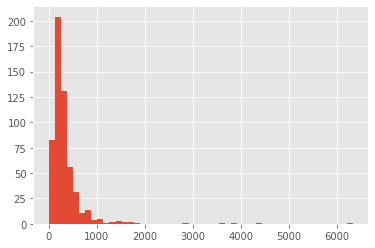

In [43]:
data2["monetary_value"].hist(bins=50)

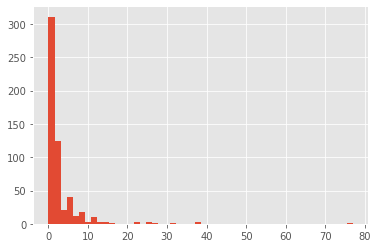

In [44]:
data2["frequency"].hist(bins=50)

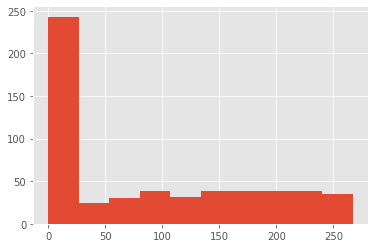

In [47]:
data2["recency"].hist(bins=10)

In [481]:
X_train[X_train["CustomerID"] == 17069]

,CustomerID,first_purchase_date,last_purchase_date,total_purchases,total_purchase_amount_x,last_2_months_spend,T,recency,frequency
901,17069.0,2010-12-01,2011-09-23,9,2004.43,545.78,304,296,8


In [482]:
X_train[X_train["CustomerID"] == 14461]

,CustomerID,first_purchase_date,last_purchase_date,total_purchases,total_purchase_amount_x,last_2_months_spend,T,recency,frequency
2923,14461.0,2011-03-23,2011-07-14,3,2103.06,0.0,192,113,2


In [483]:
data2.loc[901]

frequency                8.000000
recency                296.000000
T                      304.000000
monetary_value         222.714444
predicted_purchases      1.487008
predict_avg_amount     236.926814
Name: 901, dtype: float64

In [517]:
data2.loc[1182]

frequency                1.000000
recency                  7.000000
T                      262.000000
monetary_value         517.250000
predicted_purchases      0.201811
predict_avg_amount     983.244260
Name: 1182, dtype: float64

In [485]:
sales_predict[901]

352.3120861071721

In [516]:
sales_predict[1182]

198.42927351225947

In [491]:
diff = (sales_predict - sales_actual2);

In [514]:
df2 = X_train.loc[diff[abs(diff) < 200].index,:]

In [494]:
diff[abs(diff) < 100].index

Int64Index([3359, 1262, 2952, 3421, 1407, 3533, 2040, 3366, 1615, 2468,
            ...
            1735, 3215, 2202,  176, 1595, 3476, 2314, 2940,  767, 1555],
           dtype='int64', length=838)

In [518]:
df2[df2["total_purchases"] >8 ][df2["total_purchase_amount_x"] < 1200]

/home/vince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,CustomerID,first_purchase_date,last_purchase_date,total_purchases,total_purchase_amount_x,last_2_months_spend,T,recency,frequency
2596,17848.0,2010-12-16,2011-09-19,9,901.20,228.32,289,277,8
2106,15304.0,2010-12-06,2011-09-15,9,568.40,90.60,299,283,8
2683,16359.0,2011-01-12,2011-09-06,9,1120.68,164.40,262,237,8
2505,13491.0,2010-12-02,2011-07-15,9,1088.45,0.00,303,225,8
863,12877.0,2010-12-16,2011-09-22,10,1160.37,201.54,289,280,9


In [626]:
sales_predict - sales_actual2

1666           NaN
3575           NaN
1535    239.981901
606            NaN
1249    -90.468356
           ...    
1952     10.862402
3016           NaN
1679     10.235991
681      26.151571
2881           NaN
Length: 586, dtype: float64